<h1>Tweets Clustering</h1>

Coronavirus tweets analysis by clustering tweets' text tf-idf representation.

In [0]:
# imports
import pyspark.sql.functions as F
from pyspark.ml.feature import HashingTF, IDF, Tokenizer,CountVectorizer, StopWordsRemover, PCA
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import string
from pyspark.sql.types import ArrayType, StringType

In [0]:
# load data
tweets = spark.read.json('/mnt/ddscoursedatabricksstg/ddscoursedatabricksdata/coronavirus-tweets/')

<h2>Data Filtering</h2>

We have decided to filter out only tweets written in english, to avoid clusters of non-english tweets.
<br>Moreover, we have decided to ignore tweets who are identical w.r.t text AND user id.

In [0]:
# features relevant for analysis after clustering
tweets = tweets.withColumn("user_fol", F.explode(F.array(tweets.user).getItem("followers_count")))
tweets = tweets.withColumn("user_friends", F.explode(F.array(tweets.user).getItem("friends_count")))

# filter data
tweets.createOrReplaceTempView("tweets")
filtered = spark.sql("select id_str, text, user from tweets where lang='en'")

# identical tweets regarding to ['user_id','text'] -> we will ignore them
filtered = filtered.withColumn("user_id", F.explode(F.array(filtered.user).getItem('id_str')))
filtered = filtered.dropDuplicates(['user_id','text']).drop('user', 'user_id')


<h2>Text Pre Processing</h2>

By the following steps (for each tweet):
  * Create a list of words from text.
  * English standard stop words removal, and removal of punctuations.
  * TF-IDF representation (with dimension of 5k).
  * Filtering out empty tweets.

In [0]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(filtered)

def remove_punc(word):
  return word.translate(str.maketrans('', '', string.punctuation))

def words_filter(l):
  to_return = []
  i = 0
  while i < len(l):
    word = l[i]
    if word=='rt':
      i = i+2
      continue
    w = remove_punc(word)   
    if len(w)!=0:
      to_return.append(w)
    i = i + 1
  return to_return

words_filter_udf = F.udf(words_filter, ArrayType(StringType()))

wordsData = wordsData.withColumn("punc_free", words_filter_udf(F.col("words")))

remover = StopWordsRemover(inputCol="punc_free", outputCol="filtered")
wordsData = remover.transform(wordsData)

@udf
def length(l):
  return l.numNonzeros()

cv = CountVectorizer(inputCol="filtered", outputCol="tf", vocabSize=5000)
cv_model = cv.fit(wordsData)
vocab = cv_model.vocabulary
tf = cv_model.transform(wordsData)

tf.cache()
idf = IDF(inputCol="tf", outputCol="features").fit(tf)
tfidf = idf.transform(tf)


tfidf = tfidf.withColumn("len", length(F.col("features")))
tfidf = tfidf.where(tfidf.len!=0).drop('len')

<h2>Clustering</h2>

Run KMeans on the tf-idf vectors with cosine similarity.
<br>Before running the clustering algorithm we have dropped duplicated w.r.t text, in order to prevent affection on the centroids

In [0]:
# clustering
k = 15
kmeans = KMeans(k=k, seed = 42, distanceMeasure='cosine')
model = kmeans.fit(tfidf.select("features").dropDuplicates())  # dropDuplicates in order to prevent duplicates to affect the centroids

<h2>Join</h2>

Re-attaching prediction with original tweets data.

In [0]:
# join original tweet_id with the predictions
res = model.summary.predictions
clustered_tweets = tfidf.join(res, 'features').select('id_str','prediction', 'text', 'filtered', 'features')
display(clustered_tweets)

id_str,prediction,text,filtered,features
1224591309404397569,5,Patients going into the new hospital Wuhan Jiayou! #Wuhan stay strong! #China stay strong! #coronavirus,"List(patients, going, new, hospital, wuhan, jiayou, wuhan, stay, strong, china, stay, strong, coronavirus)","List(0, 5000, List(0, 1, 2, 7, 8, 19, 180, 189, 942, 2411), List(0.751371479945928, 1.7552400332607243, 4.137549467419848, 3.0201871775331193, 3.033291723553685, 3.4633794836463023, 4.726993435003678, 9.553937541103934, 12.539386150575409, 7.415396971489665))"
1224324967891963905,10,"RT @IndoPac_Defence: #Huoshenshan #Hospital, one of the two makeshift hospitals being built for #coronavirus patients in #Wuhan, #China, ha…","List(huoshenshan, hospital, one, two, makeshift, hospitals, built, coronavirus, patients, wuhan, china, ha…)","List(0, 5000, List(0, 1, 2, 7, 19, 20, 33, 79, 165, 314, 626, 1856), List(0.751371479945928, 1.7552400332607243, 2.068774733709924, 3.0201871775331193, 3.4633794836463023, 3.519886915945167, 3.64120569702218, 4.264921201944898, 4.681846589097081, 5.204430766301149, 5.842075162538407, 6.987952956662725))"
1224562642871701504,13,RT @Apex_WW: #NEW: #Macau reports first case of human-to-human transmission of new #coronavirus. - BNO #Wuhan #China,"List(new, macau, reports, first, case, humantohuman, transmission, new, coronavirus, bno, wuhan, china)","List(0, 5000, List(0, 1, 2, 8, 21, 24, 179, 489, 796, 2410), List(0.751371479945928, 1.7552400332607243, 2.068774733709924, 6.06658344710737, 3.5296533715332727, 3.5767159036830156, 4.721109811124095, 5.6211249381257264, 6.148537953731237, 7.354402458786823))"
1224569118961082369,13,RT @Apex_WW: #NEW: #Macau reports first case of human-to-human transmission of new #coronavirus. - BNO #Wuhan #China,"List(new, macau, reports, first, case, humantohuman, transmission, new, coronavirus, bno, wuhan, china)","List(0, 5000, List(0, 1, 2, 8, 21, 24, 179, 489, 796, 2410), List(0.751371479945928, 1.7552400332607243, 2.068774733709924, 6.06658344710737, 3.5296533715332727, 3.5767159036830156, 4.721109811124095, 5.6211249381257264, 6.148537953731237, 7.354402458786823))"
1224561900836597762,13,#NEW: #Macau reports first case of human-to-human transmission of new #coronavirus. - BNO #Wuhan #China,"List(new, macau, reports, first, case, humantohuman, transmission, new, coronavirus, bno, wuhan, china)","List(0, 5000, List(0, 1, 2, 8, 21, 24, 179, 489, 796, 2410), List(0.751371479945928, 1.7552400332607243, 2.068774733709924, 6.06658344710737, 3.5296533715332727, 3.5767159036830156, 4.721109811124095, 5.6211249381257264, 6.148537953731237, 7.354402458786823))"
1224257429329727489,6,RT @TewariAlok: #coronavirus is of Wuhan China origin & limited mostly to China as of now. But there is one virus which is effecting whole…,"List(coronavirus, wuhan, china, origin, amp, limited, mostly, china, one, virus, effecting, whole…)","List(0, 5000, List(0, 1, 2, 10, 12, 20, 2659, 3279, 3870), List(0.751371479945928, 3.5104800665214486, 2.068774733709924, 3.1765256086430136, 3.2993196362006034, 3.519886915945167, 7.49115119395466, 7.774770972397562, 8.016096842794962))"
1224254188546396160,6,RT @TewariAlok: #coronavirus is of Wuhan China origin & limited mostly to China as of now. But there is one virus which is effecting whole…,"List(coronavirus, wuhan, china, origin, amp, limited, mostly, china, one, virus, effecting, whole…)","List(0, 5000, List(0, 1, 2, 10, 12, 20, 2659, 3279, 3870), List(0.751371479945928, 3.5104800665214486, 2.068774733709924, 3.1765256086430136, 3.2993196362006034, 3.519886915945167, 7.49115119395466, 7.774770972397562, 8.016096842794962))"
1224258439783702528,6,RT @TewariAlok: #coronavirus is of Wuhan China origin & limited mostly to China as of now. But there is one virus which is effecting whole…,"List(coronavirus, wuhan, china, origin, amp, limited, mostly, china, one, virus, effecting, whole…)","List(0, 5000, List(0, 1, 2, 10, 12, 20, 2659, 3279, 3870), List(0.751371479945928, 3.510480066

<h2>Clusters Sizes:</h2>

In [0]:
# size of clusters
clustered_tweets = clustered_tweets.repartition(k, 'prediction')
clustered_tweets.groupby('prediction').count().sort('prediction').show()

+----------+------+
prediction| count|
+----------+------+
 0|226895|
 1| 83546|
 2| 40485|
 3| 19964|
 4| 9040|
 5| 62650|
 6|130858|
 7| 65044|
 8| 47939|
 9| 78090|
 10| 90523|
 11| 39023|
 12| 78426|
 13| 68868|
 14|273696|
+----------+------+

<h2>Derive Clusters' Keywords</h2>

Retrieve top t words for each cluster by taking the t argmax words w.r.t tf-idf value of the centroids.

In [0]:
# retrieve top t words for each cluster
t = 10
keywords_dct = {}
for c in range(k):
  print("Cluster #",c)
  indx = model.clusterCenters()[c].argsort()[-t:][::-1]
  keywords_dct[c] = [vocab[i] for i in indx]
  print(keywords_dct[c])
  print()

Cluster # 0
['get', 'coronavirus', 'know', 'one', 'dont', 'think', 'need', 'going', 'time', 'see']

Cluster # 1
['cases', 'confirmed', 'new', 'deaths', 'coronavirus', 'total', 'number', 'update', 'reported', 'china']

Cluster # 2
['2020', 'hope', '2', 'rate', '1', '3', 'february', '4', 'coronavirus', 'feb']

Cluster # 3
['latest', 'thanks', 'daily', 'coronavirus', 'news', 'superbowl', 'update', 'china', 'health', 'updates']

Cluster # 4
['best', 'follow', 'link', 'coronavirus', 'updates', 'news', 'way', 'click', 'china', 'us']

Cluster # 5
['please', 'stay', 'safe', 'everyone', 'keep', 'hands', 'go', 'wash', 'coronavirus', 'home']

Cluster # 6
['china', 'coronavirus', 'flights', 'travel', 'death', 'wuhan', 'outbreak', 'us', 'toll', 'news']

Cluster # 7
['hong', 'kong', 'hongkong', 'support', 'hk', 'border', 'close', 'strike', 'medical', 'carrie']

Cluster # 8
['coronavirusoutbreak', 'good', 'coronaviruschina', 'china', 'coronavirus', 'news', 'wuhan', 'know', 'virus', 'corona']

Cluster # 9
['people', 'cruise', 'ship', 'infected', 'coronavirus', 'china', 'quarantined', 'japan', 'passengers', 'wuhan']

Cluster # 10
['hospital', 'days', '10', 'patients', 'wuhan', 'built', 'hospitals', 'coronavirus', 'build', 'china']

Cluster # 11
['like', 'corona', 'virus', 'looks', 'coronavirus', 'china', 'كورونا', 'people', 'flu', 'look']

Cluster # 12
['chinese', 'government', 'coronavirus', 'people', 'wuhan', 'china', 'outbreak', 'virus', 'authorities', 'city']

Cluster # 13
['virus', 'case', 'first', 'coronavirus', 'india', 'confirmed', 'details', 'kerala', 'gt', 'patient']

Cluster # 14
['coronavirus', 'health', 'wuhan', 'outbreak', '2019ncov', 'amp', 'us', 'global', 'news', 'public']

For example, it seems like: 
* cluster #1 is related to news and updates (with keywords like: confirmed, update, reported, etc) 
* cluster #5 is related to guidelines and instructions to public (with keywords like: stay, home, wash, hands, etc)
* cluster #9 is related to japan cruise coronavirus cases (with keywords like: cruise, japan, ship, etc)

In [0]:
clustered_tweets = clustered_tweets.join(tweets, 'id_str').select('id_str','prediction','source','tweets.text','user_fol','user_friends')

<h2>Clusters Analysis</h2>

Average of the tweets publishers' followers:

In [0]:
#clustered_tweets favorite_count
display(clustered_tweets.groupby('prediction').avg('user_fol').sort('prediction'))

prediction,avg(user_fol)
0,6666.922574647223
1,21695.498456104237
2,13299.4241366687
3,20378.706386138612
4,14642.371313087175
5,9815.05722948946
6,22653.326847661003
7,14620.106598445282
8,20411.291858806013
9,16850.459951257086


Average of the tweets publishers' friends:

In [0]:
#clustered_tweets favorite_count
display(clustered_tweets.groupby('prediction').avg('user_friends').sort('prediction'))

prediction,avg(user_friends)
0,1355.993439861028
1,1862.8431425296499
2,1548.7524832214765
3,2159.1055445544553
4,2055.8075158400698
5,1031.9791402082803
6,1738.6843958501772
7,1230.214047127414
8,1838.1172894394012
9,1755.6123675670215


We can notice, for example, that cluster #5 publisher has relatively small amount of both followers and friends.
<br>Possible explenation might be that guidlines published in this cluster are non-official (the common people), as opposed to cluster #1 whos publishers have relatively high amount of these features.

Find and display top 5 sources (for all tweets together):

In [0]:
# find top 5 popular sources
from pyspark.sql.functions import col, desc

@udf
def name(s):
  tmp1 = s.split('>')[-2]
  res = tmp1.split('<')[0]
  return res

gb_source = tweets.groupBy("source").count().sort(desc("count"))
gb_source_n = gb_source.withColumn("source_name", name(col("source"))).select("source_name", "count") # alter source name
display(gb_source_n.limit(5)) # display only top 5 sources

source_name,count
Twitter for Android,924932
Twitter for iPhone,726229
Twitter Web App,458778
Twitter for iPad,61032
TweetDeck,27206


For each cluster find and display the amount and ratio of each source:

In [0]:
# count tweets per popular source for each cluster
pop_sources = gb_source_n.limit(5).select("source_name").collect()
pop_sources_set = set([x.source_name for x in list(pop_sources)])
clustered_tweets = clustered_tweets.withColumn("source_name", name(F.col('source')))
gb_source = clustered_tweets.where(clustered_tweets.source_name.isin(pop_sources_set)).groupBy("source_name","prediction").count()
display(gb_source.sort('prediction')) 

source_name,prediction,count
Twitter for iPad,0,6232
TweetDeck,0,1518
Twitter Web App,0,42006
Twitter for iPhone,0,92139
Twitter for Android,0,82402
Twitter for iPad,1,2887
Twitter Web App,1,17981
TweetDeck,1,1175
Twitter for iPhone,1,30020
Twitter for Android,1,29617


<h2>PCA</h2>

Clustering on short text about the same main subject - the corovavirus - might be inaccurate. 
<br>The varience of the data is relatively small, espacially in lower dimensions as seen in the PCA visualization below (data is reduced to 2D points):

In [0]:
# PCA visualization of the tweets tf-idf vectors
from pyspark.ml.feature import PCA

df = res.select("features", "prediction")

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)

result = model.transform(df)

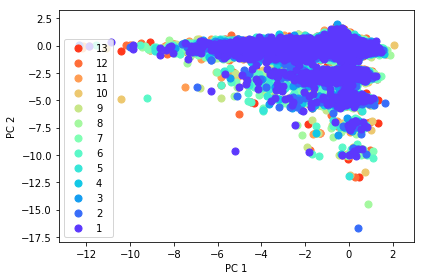

In [0]:
# PCA visualization of the tweets tf-idf vectors - cont.
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X_pca = result.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)
y = result.rdd.map(lambda row: row.prediction).collect()


def plot_pca(X_pca, y):
    colors = cm.rainbow(np.linspace(0, 1, k))
    target = np.unique(y)
    for idx in range(k):
        if idx == 0 or idx == 14:
          continue
        t = target[k-idx-1]
        color = colors[k-idx-1]
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50, c = color, label = t)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.show()

plot_pca(X_pca, y)

Note: in the PCA scatter plot, points from the biggest clusters #0 and #14 are hidden.

<h2>Summarize</h2>

Although it can be easily seen that the PCA does not preserve the data variance, we have seen that representing clusters' keyword indicate a difference between texts assigned to separate clusters.

We chose to cluster the data to K=15 clusters because:
* We wanted to maximize the difference between the clusters.
* We wanted visualize some properties of the cluster, thus we have picked K to be not too large.

We have clustered the data by the text itself because text is the core of the tweet object, and it is the richest feature of the data.